# About this notebook

This notebook is an example of how to perform the following tasks:
* Read one- and two-channel timelapse images into the notebook
* Create a file saving structure for notebook outputs
* Registration of timelapse data to compensate for drift
* Run Stardist 2D models on the data to perform segmentations in both channels

<font color=red>Example images for running this notebook are available at.........</font>

## Python imports
The cell below deals with importing necessary packages and dependencies for running the notebook. You don't need to worry about what it does, it just needs to be run :)

In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm.notebook import tqdm
from tifffile import imread, TiffFile
from csbdeep.utils import Path, normalize
from csbdeep.io import save_tiff_imagej_compatible

import imreg_dft as ird

from stardist import export_imagej_rois
from stardist.models import StarDist2D

Using TensorFlow backend.


## File information
The below cell tells the code where to find the file(s) to analyse, and also any preferences you have for the analysis.

### File location
`raw_file_path` is the path where the data that you will be analysing is currently stored. On a Mac, this will normally look something like `'Users/sculley/Desktop/NR_DNA_imm/raw data'`. On Windows, it will look something like `r'D:\200311 - New Sulfoscope data\NR_DNA_imm\raw data'`. Note the difference in the slash directions, and also the rogue 'r' at the beginning of the Windows path.

Important! This code assumes that you have saved your images in multi-image .tif format, for example the stacks and hyperstacks that you can save from ImageJ/Fiji.

### Analysis options: channels
`do_two_colour` determines whether you want to do Stardist segmentation of both channels of a two-colour image. If you do, then you should set this variable to `True`. Otherwise, set it to `False`. If your data only has one channel, then you don't need to worry about what this variable is set to!

`single_channel_to_segment` allows you to specify which channel you want to segment, if your data contains >1 channel and you don't want to segment both channels. Set this value to `1` if you want to analyse the first channel, and `2` if you want to analyse the second channel. Jf your data only has one channel, set this value to `1`. The value doesn't matter or if you are analysing both channels of a two-colour dataset :-)

### Analysis options: drift correction
`do_drift_correction` lets you choose if you want to drift correct your data. If you do want to enable drift correction, set this to `True`, otherwise set it to `False`.

`reference_channel_for_drift_correction` lets you specify the channel to perform drift correction on (for a two-channel dataset). It will then apply the same drift correction to the other channel. Again, set this to `1` to use the first channel, `2` to use the second channel etc. Don't worry about this value if your data only has one channel!

In [2]:
raw_file_path = r'.\data\two-colour data\raw data'

do_two_colour = True
single_channel_to_segment = 1

do_drift_correction = False
reference_channel_for_drift_correction = 1

## Create file saving structure
The below cell finds the images in the folder you specified in `raw_file_path`. It then creates save directories in the parent folder of `raw_file_path` for the Stardist segmentation results and drift-corrected images, if you wanted to do drift-correction.

In [3]:
raw_files = sorted(Path(raw_file_path).rglob('*.tif'))
base_dir = raw_files[0].parent.parent
print(f'Base folder is {base_dir}')

n_raw_files = len(raw_files)
print(f'There are {n_raw_files} datasets to analyse :-)')
      
if do_drift_correction:
    registered_dir = base_dir/f'registered data'
    registered_dir.mkdir(exist_ok=True)

stardist_dir = base_dir/f'stardist results'
stardist_dir.mkdir(exist_ok=True)
if do_two_colour:
    stardist_1_dir = stardist_dir/f'channel 1'
    stardist_2_dir = stardist_dir/f'channel 2'
    stardist_1_dir.mkdir(exist_ok=True)
    stardist_2_dir.mkdir(exist_ok=True)

print('Successfully created save directories, yay!')

Base folder is data\two-colour data
There are 2 datasets to analyse :-)
Successfully created save directories, yay!


## Load Stardist model(s)
We need to tell the code where to find the Stardist models. You should keep your models in their own folder, called something intuitive like, well, 'models'. Point the `model_dir` variable to where this folder is, in the same way that you did for `raw_file_path` earlier.

You also want to tell the code which models to use for which channels. You do this by changing the variable names `channel_1_model_name` and `channel_2_model_name`. If you're only doing one channel, then set `channel_2_model_name` to `None`, for example: `channel_2_model_name = None`.

In [4]:
model_dir = 'models'
channel_1_model_name = 'stardist-2020-elastic'
channel_2_model_name = 'stardist_dna_1'

In [5]:
if do_two_colour:
    model_1 = StarDist2D(None, name=channel_1_model_name, basedir=model_dir)
    model_2 = StarDist2D(None, name=channel_2_model_name, basedir=model_dir)
else:
    if single_channel_to_segment==1:
        model = StarDist2D(None, name=channel_1_model_name, basedir=model_dir)
    else:
        model = StarDist2D(None, name=channel_2_model_name, basedir=model_dir)






Loading network weights from 'weights_now.h5'.






Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.844602, nms_thresh=0.3.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.696284, nms_thresh=0.3.


## Set Stardist thresholds
There are two thresholds in Stardist that determine the segmentation results:
* `prob_thresh`
* `nms_thresh`

<font color=red>Uwe/Martin to write something about thresholds, maybe about using `model.export_TF()` to check in Fiji</font> 

In [6]:
prob_thresh_1 = None
nms_thresh_1 = 0.7

prob_thresh_2 = None
nms_thresh_2 = 0.7

## Define drift correction functions
The below functions define the drift correction. You don't need to worry about them!

In [7]:
def pre_process(file):
    print(f'Loading image from {file}')
    T = imread(str(file))
    
    if T.ndim==3:
        axes = 'TYX'
    elif T.ndim==4:
        axes = 'TCYX'
    else:
        raise ValueError('Image shape has incorrect number of dimensions')
    
    print(f'Data has axes {axes} with shape {T.shape}')
    
    return T, axes

def register(T, reg_ch):
    
    if T.ndim==3:
        reg_ch = None
    
    def _reg(x):
        return x if reg_ch is None else x[reg_ch]
    
    R = [T[0]]
    
    print(f'Running drift correction...')
    
    for frame in tqdm(T[1:]):
        result = ird.translation(_reg(R[-1]), _reg(frame))
        if reg_ch is None:
            freg = ird.transform_img(frame, tvec=result["tvec"])
        else:
            freg = np.stack([ird.transform_img(c, tvec=result["tvec"]) for c in frame])
        R.append(freg)
    
    reg = np.stack(R)
    
    return reg

def do_registration(T, axes, reg_ch):

    T_reg = register(T, reg_ch)
    T_reg = T_reg.astype(T.dtype)
    
    reg_file = registered_dir / (r'DRIFTCORRECTED_' + file.name)
    
    with TiffFile(str(file)) as _file:
        imagej_metadata = _file.imagej_metadata
        ome_metadata = _file.ome_metadata
        
    save_tiff_imagej_compatible(str(reg_file), T_reg, axes=axes, metadata=imagej_metadata)
    
    return T_reg

## Define StarDist functions

In [8]:
def do_stardist_prediction(model, T, channel, axes, prob_thresh, nms_thresh, out_dir):
    
    if T.ndim==3:
        timelapse = T
    elif T.ndim==4:
        timelapse = T[:,channel]
    else:
        raise ValueError('Data has unexpected number of dimensions. Weird.')
        
    # normalise
    print(f'Normalizing each frame to run Stardist', flush=True)
    timelapse = np.stack([normalize(frame, 1,99.8) for frame in timelapse])
    print(f"Timelapse has axes {axes.replace('C','')} with shape {timelapse.shape}")

    polygons = [model.predict_instances(frame, nms_thresh=nms_thresh, prob_thresh=prob_thresh)[1] for frame in tqdm(timelapse)]

    if prob_thresh is None:
        prob_string = 'default'
    else:
        prob_string = f'{prob_thresh:.2f}'
        
    if nms_thresh is None:
        nms_string  = 'default'
    else:
        nms_string = f'{nms_thresh:.2f}'
    
    roi_path = out_dir / f"{file.stem}_prob={prob_string}_nms={nms_string}"
    roi_path.parent.mkdir(parents=True, exist_ok=True)
    rois_python = Path(str(roi_path)+'.npz')
    rois_imagej = Path(str(roi_path)+'.zip')
    
    print(f'Saving ImageJ ROIs to {rois_imagej}')
    export_imagej_rois(str(rois_imagej), [poly['coord'] for poly in polygons])
          
    print(f'Saving Python rois to {rois_python}')
    np.savez(str(rois_python),
        coord  = [p['coord']  for p in polygons],
        points = [p['points'] for p in polygons],
        prob   = [p['prob']   for p in polygons],
    )

## Run analysis
The below cell is the main loop to run the analysis. It will loop through each dataset in the raw data directory, do registration if required, and then run Stardist to perform segmentations.

In [9]:
for file in raw_files:
    T, axes = pre_process(file)
    
    if do_drift_correction:
        T = do_registration(T, axes, reference_channel_for_drift_correction-1)
    
    if do_two_colour:
        print('~~ Running predictions on channel 1 ~~')
        do_stardist_prediction(model_1, T, 0, axes, prob_thresh_1, nms_thresh_1, stardist_1_dir)
        print('~~ Running predictions on channel 2 ~~')
        do_stardist_prediction(model_2, T, 1, axes, prob_thresh_2, nms_thresh_2, stardist_2_dir)
    else:
        do_stardist_prediction(model, T, single_channel_to_segment-1, axes, prob_thresh_1, nms_thresh_1, stardist_dir)

Loading image from data\two-colour data\raw data\membrane_dna_1.tif
Data has axes TCYX with shape (64, 2, 600, 600)
~~ Running predictions on channel 1 ~~
Normalizing each frame to run Stardist
Timelapse has axes TYX with shape (64, 600, 600)



Saving ImageJ ROIs to data\two-colour data\stardist results\channel 1\membrane_dna_1_prob=default_nms=0.70.zip
Saving Python rois to data\two-colour data\stardist results\channel 1\membrane_dna_1_prob=default_nms=0.70.npz
~~ Running predictions on channel 2 ~~
Normalizing each frame to run Stardist
Timelapse has axes TYX with shape (64, 600, 600)



Saving ImageJ ROIs to data\two-colour data\stardist results\channel 2\membrane_dna_1_prob=default_nms=0.70.zip
Saving Python rois to data\two-colour data\stardist results\channel 2\membrane_dna_1_prob=default_nms=0.70.npz
Loading image from data\two-colour data\raw data\membrane_dna_2.tif
Data has axes TCYX with shape (69, 2, 600, 600)
~~ Running predictions on channel 1 ~~
Normalizing each frame to run Stardist
Timelapse has axes TYX with shape (69, 600, 600)



Saving ImageJ ROIs to data\two-colour data\stardist results\channel 1\membrane_dna_2_prob=default_nms=0.70.zip
Saving Python rois to data\two-colour data\stardist results\channel 1\membrane_dna_2_prob=default_nms=0.70.npz
~~ Running predictions on channel 2 ~~
Normalizing each frame to run Stardist
Timelapse has axes TYX with shape (69, 600, 600)



Saving ImageJ ROIs to data\two-colour data\stardist results\channel 2\membrane_dna_2_prob=default_nms=0.70.zip
Saving Python rois to data\two-colour data\stardist results\channel 2\membrane_dna_2_prob=default_nms=0.70.npz


## Notes from testing notebooks
* Drift-corrected images haven't maintained pixel size metadata...
   

In [10]:
T.shape

(69, 2, 600, 600)

c:\python366\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


TypeError: Invalid dimensions for image data

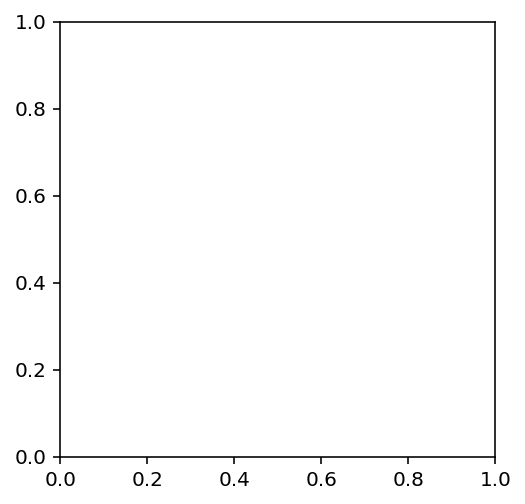

In [11]:
plt.imshow(T[0])